# **Native Language Identification**

---








# **Importing Data Set**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/dataset.csv')
raw

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


# ***Pre-Processing***

In [ ]:
# Capital to lower case
raw.Text=raw.Text.apply(lambda x: x.lower())
# Remove new line
raw.Text=raw.Text.replace('\n',' ', regex=True)
# Removing puntuations
raw.Text=raw.Text.str.replace(r'[^\w\s]+', ' ',regex=True)

In [ ]:
# function to from to remove emojis
import re
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

raw['Text'] = raw['Text'].apply(lambda x: remove_emoji(x))
raw

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจร ญกร ง อ กษรโรม น thanon charoen krung เ...,Thai
3,வ ச கப பட ட னம தம ழ ச சங கத த இந த ப பத த ர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หล กจากท เสด จประพาสแหลมมลาย ชวา อ นเด...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,mai k baby i like bip record love day aft...,Chinese


In [ ]:
# Languages
languages = set(raw['language'])
# print('Languages', languages)
# print('========')
# # Examples of multiple langs taken from heads and tails
# print('Swedish & English:', raw['Text'][1])
# print('Thai & English:', raw['Text'][2])
# print('Chinese & English:', raw['Text'][21998])

# ***Train-Test Split***

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X=raw['Text']
y=raw['language']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

17600
4400
17600
4400


In [ ]:
print(X_test.iloc[2:3])

8732    bagnizeau est commune francicum  incolarum ann...
Name: Text, dtype: object


# ***Feature Extraction (Unigrams)***

In [ ]:
# Extract Unigrams
from sklearn.feature_extraction.text import CountVectorizer
unigramVectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1))
X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
X_unigram_test_raw = unigramVectorizer.transform(X_test)

unigramFeatures = unigramVectorizer.get_feature_names()

print('Number of unigrams in training set:', len(unigramFeatures))

Number of unigrams in training set: 6816


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test.describe()

count                                                  4400
unique                                                 4381
top       haec commentatio automatice praeparata res ast...
freq                                                     10
Name: Text, dtype: object

In [ ]:
# Aggregate Unigrams per language
def train_lang_dict(X_raw_counts, y_train):
    lang_dict = {}
    for i in range(len(y_train)):
        lang = y_train[i]
        v = np.array(X_raw_counts[i])
        if not lang in lang_dict:
            lang_dict[lang] = v
        else:
            lang_dict[lang] += v
            
    # to relative
    for lang in lang_dict:
        v = lang_dict[lang]
        lang_dict[lang] = v / np.sum(v)
        
    return lang_dict

language_dict_unigram = train_lang_dict(X_unigram_train_raw.toarray(), y_train.values)

# Collect relevant chars per language
def getRelevantCharsPerLanguage(features, language_dict, significance=1e-5):
    relevantCharsPerLanguage = {}
    for lang in languages:
        chars = []
        relevantCharsPerLanguage[lang] = chars
        v = language_dict[lang]
        for i in range(len(v)):
            if v[i] > significance:
                chars.append(features[i])
    return relevantCharsPerLanguage

relevantCharsPerLanguage = getRelevantCharsPerLanguage(unigramFeatures, language_dict_unigram)
    
# Print number of unigrams per language
for lang in languages:    
    print(lang, len(relevantCharsPerLanguage[lang]))

Arabic 97
Spanish 66
Tamil 113
Dutch 58
Estonian 96
Thai 148
Persian 98
Portugese 64
English 60
Korean 1407
Pushto 188
Urdu 142
Romanian 109
Hindi 117
Turkish 121
Japanese 2054
Chinese 3249
Indonesian 75
French 70
Swedish 77
Russian 85
Latin 132


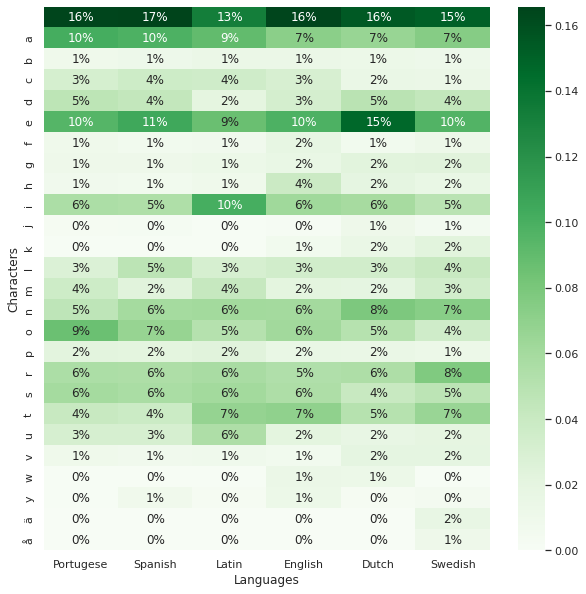

In [ ]:
# get most common chars for a few European languages
europeanLanguages = ['Portugese', 'Spanish', 'Latin', 'English', 'Dutch', 'Swedish']
relevantChars_OnePercent = getRelevantCharsPerLanguage(unigramFeatures, language_dict_unigram, 1e-2)

# collect and sort chars
europeanCharacters = []
for lang in europeanLanguages:
    europeanCharacters += relevantChars_OnePercent[lang]
europeanCharacters = list(set(europeanCharacters))
europeanCharacters.sort()

# build data
indices = [unigramFeatures.index(f) for f in europeanCharacters]
data = []
for lang in europeanLanguages:
    data.append(language_dict_unigram[lang][indices])

#build dataframe
df = pd.DataFrame(np.array(data).T, columns=europeanLanguages, index=europeanCharacters)
df.index.name = 'Characters'
df.columns.name = 'Languages'

# plot heatmap
import seaborn as sn
import matplotlib.pyplot as plt
sn.set(font_scale=0.8) # for label size
sn.set(rc={'figure.figsize':(10, 10)})
sn.heatmap(df, cmap="Greens", annot=True, annot_kws={"size": 12}, fmt='.0%')# font size
plt.show()

In [ ]:
# Define some functions for our purpose

from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn
import matplotlib.pyplot as plt
import scipy

# Utils for conversion of different sources into numpy array
def toNumpyArray(data):
    data_type = type(data)
    if data_type == np.ndarray:
        return data
    elif data_type == list:
        return np.array(data_type)
    elif data_type == scipy.sparse.csr.csr_matrix:
        return data.toarray()
    print(data_type)
    return None


def normalizeData(train):
    train_result = normalize(train, norm='l2', axis=1, copy=True, return_norm=False)
    # test_result = normalize(test, norm='l2', axis=1, copy=True, return_norm=False)
    return train_result

def plot_F_Scores(y_test, y_predict):
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

def plot_Confusion_Matrix(y_test, y_predict, color="Blues"):
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    unqiueLabel = np.unique(allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=unqiueLabel, index=unqiueLabel)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    sn.set(font_scale=0.8) # for label size
    sn.set(rc={'figure.figsize':(15, 15)})
    sn.heatmap(df_cm, cmap=color, annot=True, annot_kws={"size": 12}, fmt='g')# font size
    plt.show()

# ***Model Building***

F1: 0.9538636363636362 (micro), 0.9545871978993322 (macro), 0.9545028869296119 (weighted)


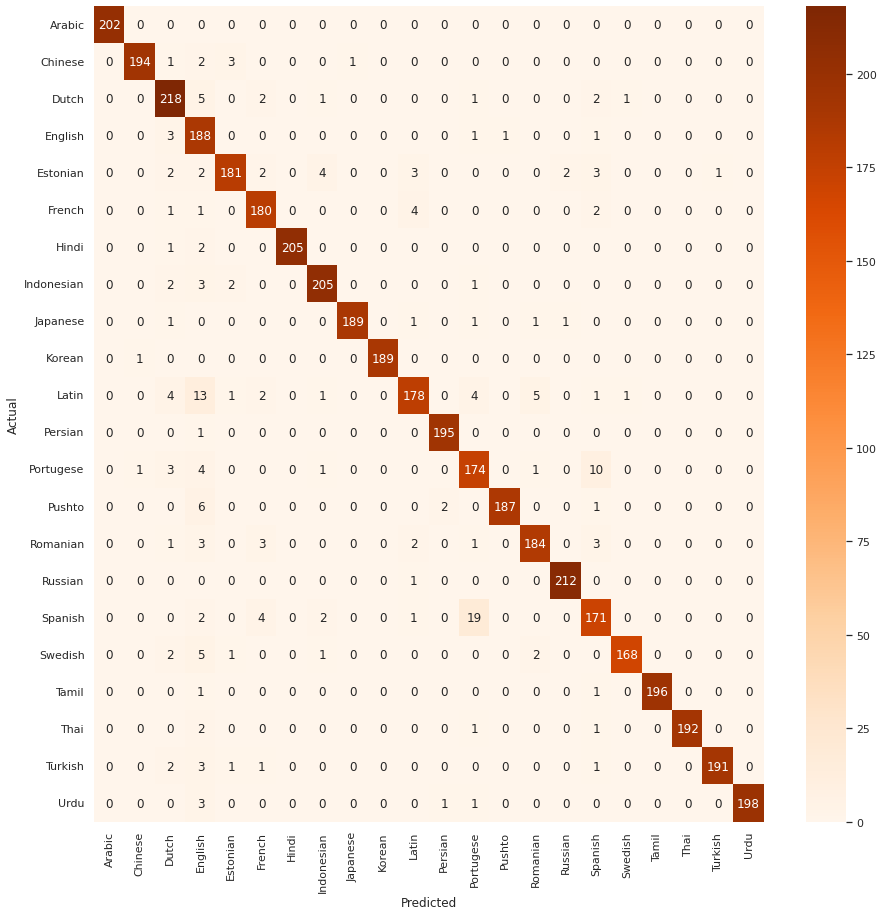

In [ ]:
def applyKNN(X_train, y_train):
    trainArray = toNumpyArray(X_train)
    
    clf = KNeighborsClassifier()

    clf.fit(trainArray, y_train)
    
    return clf

X_unigram_train = normalizeData(X_unigram_train_raw)
X_unigram_test = normalizeData(X_unigram_test_raw)
y_predict_knn_unigram_model = applyKNN(X_unigram_train, y_train)

testArray = toNumpyArray(X_unigram_test)
y_predict_knn_unigram = y_predict_knn_unigram_model.predict(testArray)
plot_F_Scores(y_test, y_predict_knn_unigram)
plot_Confusion_Matrix(y_test, y_predict_knn_unigram, "Oranges")

In [ ]:
# Input Text
input_text = "Она моя подруга"
test_text = unigramVectorizer.transform([input_text])
res_test = toNumpyArray(normalizeData(test_text)) 

# Prediction
y_predict_knn_unigram_model.predict(res_test)

array(['Russian'], dtype=object)

F1: 0.9245454545454546 (micro), 0.9228036807514023 (macro), 0.9201996483569281 (weighted)


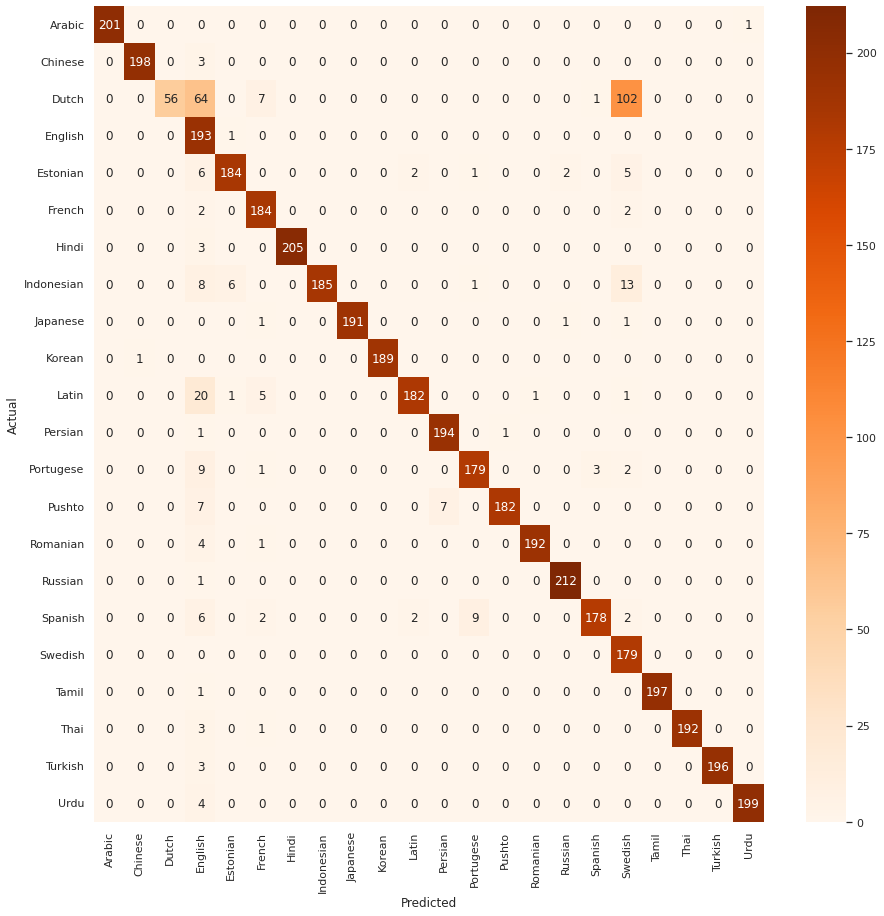

In [ ]:
# Naive Bayes

def applyNaiveBayes(X_train, y_train):
    trainArray = toNumpyArray(X_train)

    clf = MultinomialNB()

    clf.fit(trainArray, y_train)

    return clf

X_unigram_train = normalizeData(X_unigram_train_raw)
X_unigram_test = normalizeData(X_unigram_test_raw)
y_predict_mnb_unigram_model = applyNaiveBayes(X_unigram_train, y_train)

testArray = toNumpyArray(X_unigram_test)
y_predict_mnb_unigram = y_predict_mnb_unigram_model.predict(testArray)
plot_F_Scores(y_test, y_predict_mnb_unigram)
plot_Confusion_Matrix(y_test, y_predict_mnb_unigram, "Oranges")

In [ ]:
# Input Text
input_text = "Elle est ma petite amie"
test_text = unigramVectorizer.transform([input_text])
res_test = toNumpyArray(normalizeData(test_text)) 

# Prediction
y_predict_mnb_unigram_model.predict(res_test)

array(['French'], dtype='<U10')

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
def applySVM(X_train, y_train):
    trainArray = toNumpyArray(X_train)
    
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

    clf.fit(trainArray, y_train)
    
    return clf

F1: 0.9086363636363637 (micro), 0.9104608742401024 (macro), 0.9111291391147868 (weighted)


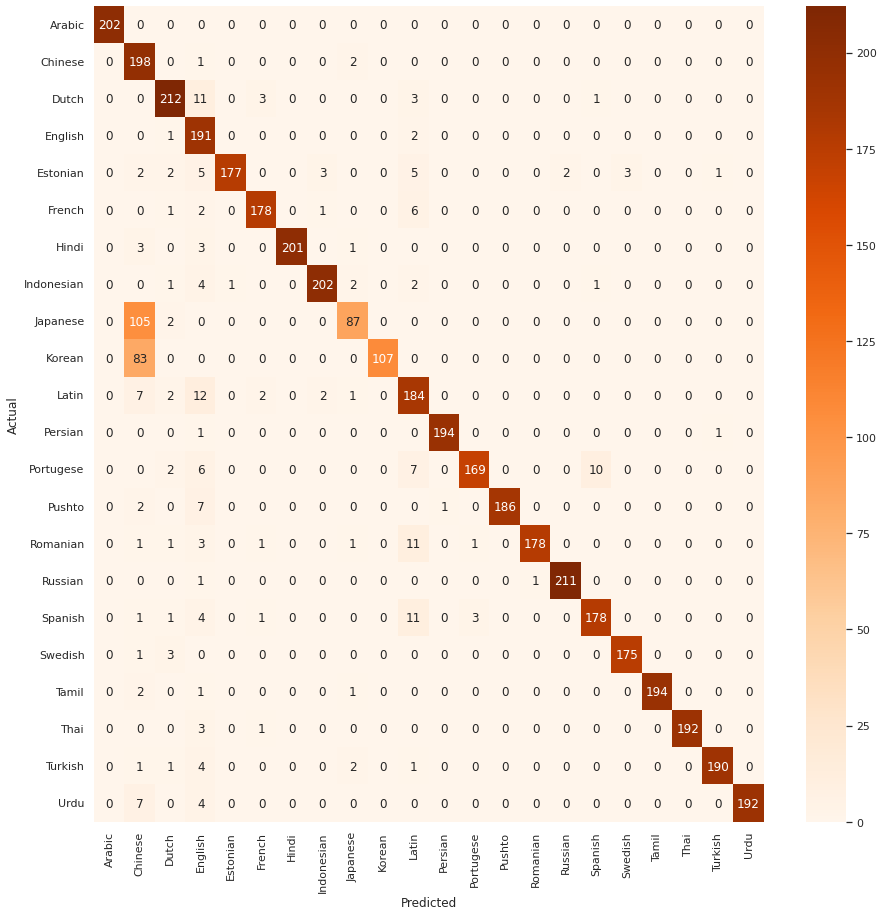

In [ ]:
# SVM
X_unigram_train = normalizeData(X_unigram_train_raw)
X_unigram_test = normalizeData(X_unigram_test_raw)
y_predict_svm_unigram_model = applySVM(X_unigram_train, y_train)

testArray = toNumpyArray(X_unigram_test)
y_predict_svm_unigram = y_predict_svm_unigram_model.predict(testArray)
plot_F_Scores(y_test, y_predict_svm_unigram)
plot_Confusion_Matrix(y_test, y_predict_svm_unigram, "Oranges")

In [ ]:
# Input Text
input_text = "un pequeño paso para el hombre un gran salto para la humanidad"
test_text = unigramVectorizer.transform([input_text])
res_test = toNumpyArray(normalizeData(test_text)) 

# Prediction
y_predict_svm_unigram_model.predict(res_test)

array(['Spanish'], dtype=object)

In [ ]:
from sklearn.naive_bayes import GaussianNB
def applyGaussianNaiveBayes(X_train, y_train):
    trainArray = toNumpyArray(X_train)

    clf = GaussianNB()

    clf.fit(trainArray, y_train)

    return clf

F1: 0.7945454545454546 (micro), 0.7767204464195605 (macro), 0.770583137919831 (weighted)


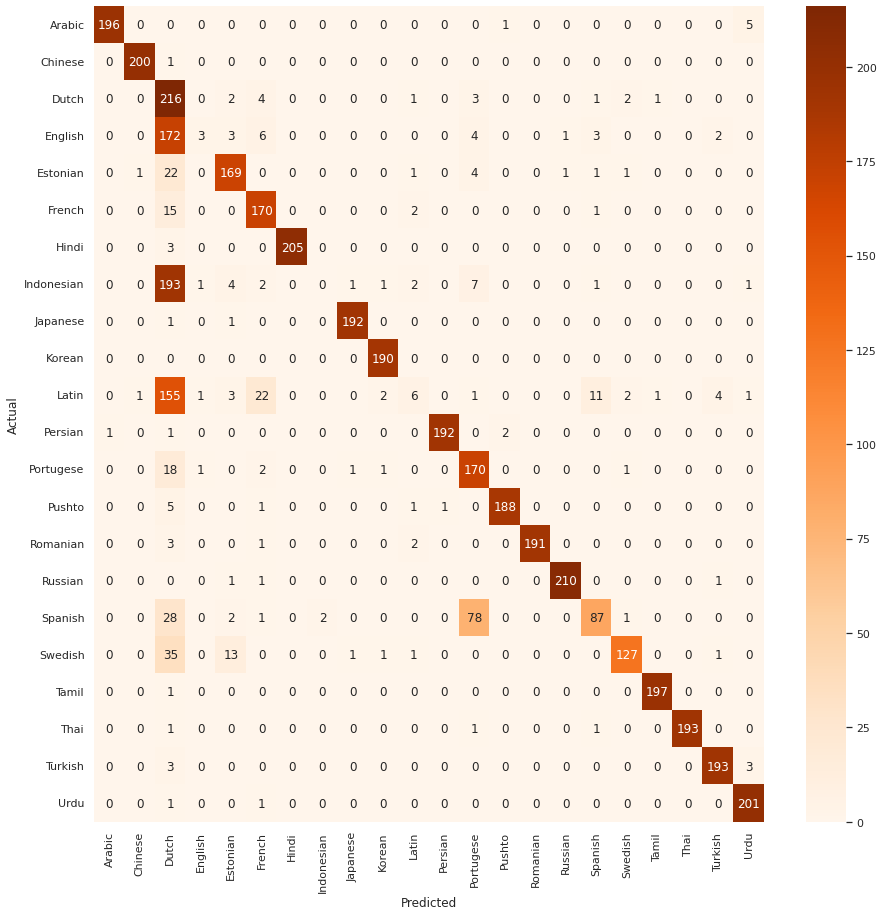

In [ ]:
X_unigram_train = normalizeData(X_unigram_train_raw)
X_unigram_test = normalizeData(X_unigram_test_raw)
y_predict_gnb_unigram_model = applyGaussianNaiveBayes(X_unigram_train, y_train)

testArray = toNumpyArray(X_unigram_test)
y_predict_gnb_unigram = y_predict_gnb_unigram_model.predict(testArray)
plot_F_Scores(y_test, y_predict_gnb_unigram)
plot_Confusion_Matrix(y_test, y_predict_gnb_unigram, "Oranges")

In [ ]:
# Input Text
input_text = "un pequeño paso para el hombre un gran salto para la humanidad"
test_text = unigramVectorizer.transform([input_text])
res_test = toNumpyArray(normalizeData(test_text)) 

# Prediction
y_predict_gnb_unigram_model.predict(res_test)

array(['Spanish'], dtype='<U10')

# ***Final Result***

In [ ]:
input_text = "他是个好老师"
test_text = unigramVectorizer.transform([input_text])
res_test = toNumpyArray(normalizeData(test_text)) 

In [ ]:
import collections

# Prediction
outputs = [0, 0, 0, 0]

outputs[0] = str(y_predict_knn_unigram_model.predict(res_test))
outputs[1] = str(y_predict_mnb_unigram_model.predict(res_test))
outputs[2] = str(y_predict_gnb_unigram_model.predict(res_test))
outputs[3] = str(y_predict_svm_unigram_model.predict(res_test))


freq = dict(collections.Counter(outputs))

for i in range(4):
  print(outputs[i])

result = max(zip(freq.values(), freq.keys()))[1]

print(f"Result from ensemble model: {result}")

['Chinese']
['Chinese']
['Chinese']
['Chinese']
Result from ensemble model: ['Chinese']
